#Journal recommendation algorithm by finding topic related articles and extracting journal info from them

The solution consits of a number of topics using LDA (Latent Dirichlet Allocation), which shows us  each article as a mixture of these topics. By mapping a specific article into the topic space (a simplex with a topic in each corner), we can then find related articles, and then choose journals where they were published as the most suitable for scpecific areticle publication

**What is LDA?**

Topic modeling is a method for unsupervised classification of documents, similar to clustering on numeric data, which finds some natural groups of items (topics) even when we’re not sure what we’re looking for.
̐

**There are 2 parts in LDA:**

1) The words that belong to a document, that we already know.

2) The words that belong to a topic or the probability of words belonging into a topic, that we need to calculate.


**The Algorithm to find the latter**

Go through each document and randomly assign each word in the document to one of k topics (k is chosen beforehand).

For each document d, go through each word w and compute :
- p(topic t | document d): the proportion of words in document d that are assigned to topic t. Tries to capture how many words belong to the topic t for a given document d. Excluding the current word.
If a lot of words from d belongs to t, it is more probable that word w belongs to t.
( #words in d with t +alpha/ #words in d with any topic+ k*alpha)
- p(word w| topic t): the proportion of assignments to topic t over all documents that come from this word w. Tries to capture how many documents are in topic t because of word w.

LDA represents documents as a mixture of topics. Similarly, a topic is a mixture of words. If a word has high probability of being in a topic, all the documents having w will be more strongly associated with t as well. Similarly, if w is not very probable to be in t, the documents which contain the w will be having very low probability of being in t, because rest of the words in d will belong to some other topic and hence d will have a higher probability for those topic. So even if w gets added to t, it won’t be bringing many such documents to t.




#Loading all the required libraries

In [1]:
from IPython.utils import io
with io.capture_output() as captured:
    !pip install scispacy
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [2]:
!pip install nltk

!pip install spacy==2.3.5

!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz

!pip install pyresparser

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.4 MB 5.1 MB/s 
     |████████████████████████████████| 1.0 MB 45.2 MB/s 
     |████████████████████████████████| 208 kB 44.6 MB/s 
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.5
    Uninstalling srsly-2.4.5:
      Successfully uninstalled srsly-2.4.5
  Attempting uninstall: catalogue
    Found existing installation: catalogue 2.0.8
    Uninstalling catalogue-2.0.8:
      Successfully uninstalled catalogue-2.0.8
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.5
    Uninstalling thinc-8.1.5:
      Successfully uninstalled thinc-8.1.5
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.2
    Uninstalling spacy-3.4.2:
      Successfully uninstalled spacy-3.4.2
ERROR: pip's depende

In [3]:
import numpy as np 
import pandas as pd

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import scispacy
import spacy
import en_core_sci_lg

from scipy.spatial.distance import jensenshannon

import joblib

from IPython.display import HTML, display

from ipywidgets import interact, Layout, HBox, VBox, Box
import ipywidgets as widgets
from IPython.display import clear_output

from tqdm import tqdm
from os.path import isfile

import seaborn as sb
import matplotlib.pyplot as plt


import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_sci_lg' (0.2.4) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


# Loading and preprocessing dataset




In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/My Drive

/content/drive/My Drive


In [6]:
df = pd.read_csv('dois_parsed_super.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
df2 = df.loc[(df['Year'] > 2010)] 
df2

,Unnamed: 0,DOI,Title,Year,num_citiations,ISSN,Abstract
0,0,10.1016/j.jphotochemrev.2022.100534,Controlled optical manipulation and sorting of...,2022,0,13895567,NaN
1,1,10.1016/j.jphotochemrev.2022.100535,Laser-induced forward-transfer with light poss...,2022,0,13895567,NaN
2,2,10.1016/j.jphotochemrev.2022.100531,Optical manipulation with nanoscale chiral fie...,2022,0,13895567,NaN
3,3,10.1016/j.jphotochemrev.2022.100530,Manipulation of nucleation and polymorphism by...,2022,0,13895567,NaN
4,4,10.1016/j.jphotochemrev.2022.100532,Nanoscale optical imaging with photoinduced fo...,2022,0,13895567,NaN
...,...,...,...,...,...,...,...
1318411,1318411,10.3390/m717,"7-Phenyl-3,4,8,9-tetrahydro-2H-pyridazino[1,6-...",2011,1,14228599,NaN
1318412,1318412,10.3390/m716,"Copper 5,10,15,20-Tetra(N-ethyl-3-carbazolyl) ...",2011,0,14228599,NaN
1318413,1318413,10.3390/m715,(Benzoylamino)methyl 4-Acetyloxybenzoate,2011,0,14228599,NaN
1318414,1318414,10.3390/m714,"[5-(1,3-Diphenyl-1H-pyrazol-4-yl)-3-phenyl-4,5...",2011,0,14228599,NaN


In [8]:
df3 = df2.loc[(df2['Year'] < 2021)] 
df3

,Unnamed: 0,DOI,Title,Year,num_citiations,ISSN,Abstract
57,57,10.1016/j.jphotochemrev.2020.100384,Curcumin as a photosensitizer: From molecular ...,2020,24,13895567,NaN
58,58,10.1016/j.jphotochemrev.2020.100385,Supramolecular chlorophyll aggregates inspired...,2020,15,13895567,NaN
59,59,10.1016/s1389-5567(20)30057-5,IFC(EDITORIAL BOARD),2020,0,13895567,NaN
60,60,10.1016/j.jphotochemrev.2020.100355,Photodynamical behaviour of MOFs and related c...,2020,17,13895567,NaN
61,61,10.1016/j.jphotochemrev.2020.100371,Through bond energy transfer (TBET)-based fluo...,2020,20,13895567,NaN
...,...,...,...,...,...,...,...
1318411,1318411,10.3390/m717,"7-Phenyl-3,4,8,9-tetrahydro-2H-pyridazino[1,6-...",2011,1,14228599,NaN
1318412,1318412,10.3390/m716,"Copper 5,10,15,20-Tetra(N-ethyl-3-carbazolyl) ...",2011,0,14228599,NaN
1318413,1318413,10.3390/m715,(Benzoylamino)methyl 4-Acetyloxybenzoate,2011,0,14228599,NaN
1318414,1318414,10.3390/m714,"[5-(1,3-Diphenyl-1H-pyrazol-4-yl)-3-phenyl-4,5...",2011,0,14228599,NaN


In [9]:
%cd /content/drive/My Drive/Abstracts

/content/drive/My Drive/Abstracts


In [10]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

gauth = GoogleAuth()

drive = GoogleDrive(gauth)

#Now we need to download all parced abstracts from semanticscholar

In [11]:
df_abs = pd.DataFrame()
for i in range(1,41):
    txt = pd.read_csv(f'abstracts_{i}.csv')
    df_abs=df_abs.append(txt,ignore_index=True)
txt

,Unnamed: 0,DOI,Abstract
0,0,10.6023/cjoc201611004,A new macrocyclic norbornene-based bis-triazol...
1,1,10.6023/cjoc201704030,Many organometallic reactions involve three el...
2,2,10.6023/cjoc201610046,研究了在温和的反应条件和FeCl 3 作用下，各种烯基醇与碘发生分子内碘代环化反应生成碘代环...
3,3,10.6023/cjoc201607010,An efficient methodology to access of quinazol...
4,4,10.6023/cjoc201704049,A simple and efficient nickel-catalyzed oxidat...
...,...,...,...
4701,4701,10.1080/00397910903576651,"A greener, economical, and efficient methodolo..."
4702,4702,10.1080/00397910903576594,Silica sulfuric acid has been utilized as an e...
4703,4703,10.1080/00397910903538644,"Benzo[b][1,5]thiazepines 1a or 1b were prepare..."
4704,4704,10.1080/00397911003587499,An efficient one-pot synthesis of tetrahydrobe...


In [12]:
df_abs

,Unnamed: 0,DOI,Abstract
0,0,10.1039/c3np70106a,Covering: up to 2014. Dithiolopyrrolone (DTP) ...
1,1,10.1039/c3np70087a,Bioactive natural products and derivatives rem...
2,2,10.1039/c3np70083f,"This review covers the isolation, chemical str..."
3,3,10.1039/c4np90008a,The ability to recreate Nature's molecules thr...
4,4,10.1039/c4np00021h,Covering: January 1990 to December 2012. Mycob...
...,...,...,...
131423,4701,10.1080/00397910903576651,"A greener, economical, and efficient methodolo..."
131424,4702,10.1080/00397910903576594,Silica sulfuric acid has been utilized as an e...
131425,4703,10.1080/00397910903538644,"Benzo[b][1,5]thiazepines 1a or 1b were prepare..."
131426,4704,10.1080/00397911003587499,An efficient one-pot synthesis of tetrahydrobe...


In [13]:
df_cd = pd.merge(df3, df_abs, how='inner', on = 'DOI')

In [14]:
df_cd

,Unnamed: 0_x,DOI,Title,Year,num_citiations,ISSN,Abstract_x,Unnamed: 0_y,Abstract_y
0,710,10.1039/d0np00072h,Employing chemical synthesis to study the stru...,2020,8,2650568,<p>This review recounts the chemical journey f...,0,Covering: 2015 to 2020The field of natural pro...
1,718,10.1039/d0np90029j,Hot off the Press,2020,0,2650568,<p>A personal selection of 32 recent papers is...,1,A personal selection of 32 recent papers is pr...
2,719,10.1039/c9np00028c,Phenolic cross-links: building and de-construc...,2020,58,2650568,<p>Phenolic cross-links and inter-unit linkage...,2,Covering: Up to 2019Phenolic cross-links and p...
3,722,10.1039/d0np00009d,Dehydration reactions in polyfunctional natura...,2020,10,2650568,"<p>Here, we review methods for chemical dehydr...",3,"Covering: up to 2020In this review, we present..."
4,723,10.1039/d0np00016g,"Diving into the world of marine 2,11-cyclized ...",2020,15,2650568,"<p>This review summarises new marine 2,11-cycl...",4,"Covering: 2010 to 2020The class of 2,11-cycliz..."
...,...,...,...,...,...,...,...,...,...
131423,1207229,10.1080/00397910903576651,Reaction on Water: A Greener Approach for the ...,2011,6,00397911,NaN,4701,"A greener, economical, and efficient methodolo..."
131424,1207230,10.1080/00397910903576594,Efficient Solvent-Free Knoevenagel Condensatio...,2011,13,00397911,NaN,4702,Silica sulfuric acid has been utilized as an e...
131425,1207231,10.1080/00397910903538644,Utility of α-Oxoketene and α-Cyanoketene Thioa...,2011,6,00397911,NaN,4703,"Benzo[b][1,5]thiazepines 1a or 1b were prepare..."
131426,1207232,10.1080/00397911003587499,Caro's Acid–Silica Gel: An Efficient and Versa...,2011,33,00397911,NaN,4704,An efficient one-pot synthesis of tetrahydrobe...


In [15]:
df_cd = df_cd.drop(columns = ['Unnamed: 0_x', 'Abstract_x', 'Unnamed: 0_y'])
df_cd

,DOI,Title,Year,num_citiations,ISSN,Abstract_y
0,10.1039/d0np00072h,Employing chemical synthesis to study the stru...,2020,8,2650568,Covering: 2015 to 2020The field of natural pro...
1,10.1039/d0np90029j,Hot off the Press,2020,0,2650568,A personal selection of 32 recent papers is pr...
2,10.1039/c9np00028c,Phenolic cross-links: building and de-construc...,2020,58,2650568,Covering: Up to 2019Phenolic cross-links and p...
3,10.1039/d0np00009d,Dehydration reactions in polyfunctional natura...,2020,10,2650568,"Covering: up to 2020In this review, we present..."
4,10.1039/d0np00016g,"Diving into the world of marine 2,11-cyclized ...",2020,15,2650568,"Covering: 2010 to 2020The class of 2,11-cycliz..."
...,...,...,...,...,...,...
131423,10.1080/00397910903576651,Reaction on Water: A Greener Approach for the ...,2011,6,00397911,"A greener, economical, and efficient methodolo..."
131424,10.1080/00397910903576594,Efficient Solvent-Free Knoevenagel Condensatio...,2011,13,00397911,Silica sulfuric acid has been utilized as an e...
131425,10.1080/00397910903538644,Utility of α-Oxoketene and α-Cyanoketene Thioa...,2011,6,00397911,"Benzo[b][1,5]thiazepines 1a or 1b were prepare..."
131426,10.1080/00397911003587499,Caro's Acid–Silica Gel: An Efficient and Versa...,2011,33,00397911,An efficient one-pot synthesis of tetrahydrobe...


In [16]:
df_cd = df_cd.drop_duplicates()
df_cd

,DOI,Title,Year,num_citiations,ISSN,Abstract_y
0,10.1039/d0np00072h,Employing chemical synthesis to study the stru...,2020,8,2650568,Covering: 2015 to 2020The field of natural pro...
1,10.1039/d0np90029j,Hot off the Press,2020,0,2650568,A personal selection of 32 recent papers is pr...
2,10.1039/c9np00028c,Phenolic cross-links: building and de-construc...,2020,58,2650568,Covering: Up to 2019Phenolic cross-links and p...
3,10.1039/d0np00009d,Dehydration reactions in polyfunctional natura...,2020,10,2650568,"Covering: up to 2020In this review, we present..."
4,10.1039/d0np00016g,"Diving into the world of marine 2,11-cyclized ...",2020,15,2650568,"Covering: 2010 to 2020The class of 2,11-cycliz..."
...,...,...,...,...,...,...
131423,10.1080/00397910903576651,Reaction on Water: A Greener Approach for the ...,2011,6,00397911,"A greener, economical, and efficient methodolo..."
131424,10.1080/00397910903576594,Efficient Solvent-Free Knoevenagel Condensatio...,2011,13,00397911,Silica sulfuric acid has been utilized as an e...
131425,10.1080/00397910903538644,Utility of α-Oxoketene and α-Cyanoketene Thioa...,2011,6,00397911,"Benzo[b][1,5]thiazepines 1a or 1b were prepare..."
131426,10.1080/00397911003587499,Caro's Acid–Silica Gel: An Efficient and Versa...,2011,33,00397911,An efficient one-pot synthesis of tetrahydrobe...


In [17]:
df_cd.reset_index(drop=True, inplace=True)

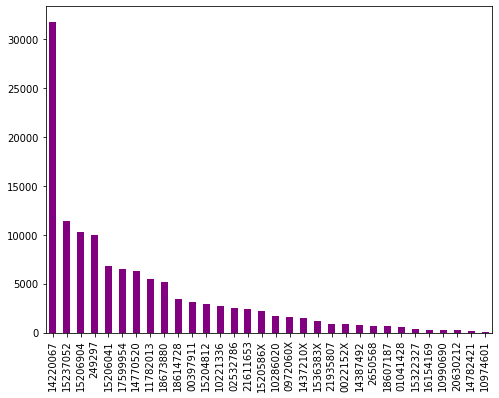

In [18]:
from matplotlib.pyplot import figure
figure(figsize=(8,6))
df_cd['ISSN'].value_counts().plot(kind='bar', color = '#800080');

**As it can be seen from the barchart upper, the dataset is imbalanced in terms of issn quantity with the majority of articles from journal with issn = 14220067. It means that further our algorythm will mostly choose similar articles from this journal**





In [19]:
df_drop = df_cd.drop(df_cd[df_cd['ISSN'] == 14220067].sample(n = 20000).index)

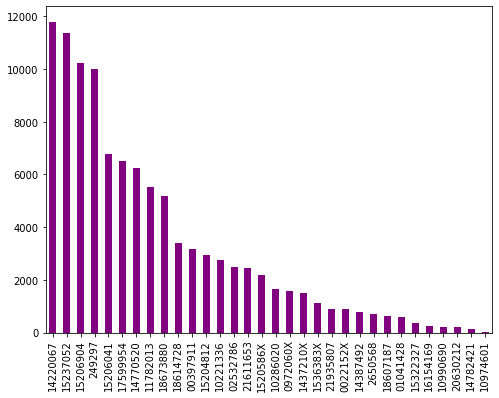

In [20]:
from matplotlib.pyplot import figure
figure(figsize=(8,6))
df_drop['ISSN'].value_counts().plot(kind='bar', color = '#800080');

Now it looks better

In [21]:
df_cd = df_drop

In [22]:
df_cd.reset_index(drop=True, inplace=True)

In [23]:
df_cd

,DOI,Title,Year,num_citiations,ISSN,Abstract_y
0,10.1039/d0np00072h,Employing chemical synthesis to study the stru...,2020,8,2650568,Covering: 2015 to 2020The field of natural pro...
1,10.1039/d0np90029j,Hot off the Press,2020,0,2650568,A personal selection of 32 recent papers is pr...
2,10.1039/c9np00028c,Phenolic cross-links: building and de-construc...,2020,58,2650568,Covering: Up to 2019Phenolic cross-links and p...
3,10.1039/d0np00009d,Dehydration reactions in polyfunctional natura...,2020,10,2650568,"Covering: up to 2020In this review, we present..."
4,10.1039/d0np00016g,"Diving into the world of marine 2,11-cyclized ...",2020,15,2650568,"Covering: 2010 to 2020The class of 2,11-cycliz..."
...,...,...,...,...,...,...
104657,10.1080/00397910903576651,Reaction on Water: A Greener Approach for the ...,2011,6,00397911,"A greener, economical, and efficient methodolo..."
104658,10.1080/00397910903576594,Efficient Solvent-Free Knoevenagel Condensatio...,2011,13,00397911,Silica sulfuric acid has been utilized as an e...
104659,10.1080/00397910903538644,Utility of α-Oxoketene and α-Cyanoketene Thioa...,2011,6,00397911,"Benzo[b][1,5]thiazepines 1a or 1b were prepare..."
104660,10.1080/00397911003587499,Caro's Acid–Silica Gel: An Efficient and Versa...,2011,33,00397911,An efficient one-pot synthesis of tetrahydrobe...


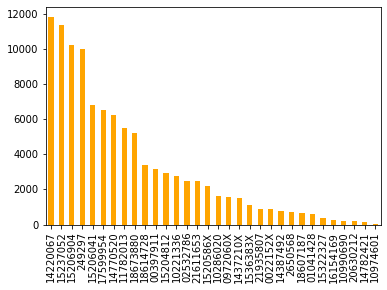

In [24]:
df_cd['ISSN'].value_counts().plot(kind='bar', color = 'orange');

In [25]:
all_texts = df_cd.Abstract_y

#LDA: preprocessing
 ScispaCy is a Python package containing spaCy models for processing biomedical, scientific or clinical text.

In [26]:
# medium model
nlp = en_core_sci_lg.load(disable=["tagger", "parser", "ner"])
nlp.max_length = 3000000

/usr/local/lib/python3.7/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_sci_lg' (0.2.4) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [27]:
def spacy_tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)]

In [28]:
# Let's create stopword list
chem_stopwords = [
    'doi', 'preprint', 'copyright', 'org', 'https', 'et', 'al', 'author', 'figure', 'table',
    'rights', 'reserved', 'permission', 'use', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI',
    '-PRON-', 'usually',
    r'\usepackage{amsbsy', r'\usepackage{amsfonts', r'\usepackage{mathrsfs', r'\usepackage{amssymb', r'\usepackage{wasysym',
    r'\setlength{\oddsidemargin}{-69pt',  r'\usepackage{upgreek', r'\documentclass[12pt]{minimal', r'<sub>', r'</sub>', r'<html>', r'</html>', r'<em>', r'</em>'
]

# Marking stopwords in vocabulary
for word in chem_stopwords:
    nlp.vocab[word].is_stop = True

In [29]:
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, min_df=2)
vectorised_d = vectorizer.fit_transform(tqdm(all_texts))

100%|██████████| 104662/104662 [04:15<00:00, 410.25it/s]


In [30]:
vectorised_d.shape

(104662, 106233)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<Figure size 576x432 with 0 Axes>

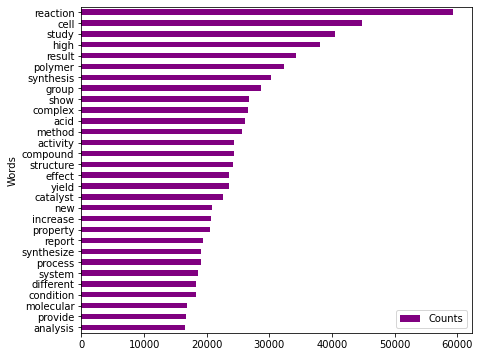

In [31]:
# Let's see the frequency of words in our texts
wordcounts = pd.DataFrame({'Words': vectorizer.get_feature_names(), 'Counts': np.asarray(vectorised_d.sum(axis=0))[0]})

from matplotlib.pyplot import figure
figure(figsize=(8,6))

wordcounts.sort_values('Counts', ascending=False).set_index('Words')[:30].sort_values('Counts', ascending=True).plot(kind='barh', color = '#800080', figsize=(7,6))


#LDA implementation

In [32]:
lda = LatentDirichletAllocation(n_components=50, random_state=0) #we can play with number of components(topics)
lda.fit(vectorised_d)

LatentDirichletAllocation(n_components=50, random_state=0)

In [33]:
def topics_topwords(model, vectorizer, num_topwords):
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        info = "\nTopic № %d: " % topic_idx
        info += " ".join([feature_names[i]
                             for i in topic.argsort()[:-num_topwords - 1:-1]])
        print(info)
    print()

In [34]:
topics_topwords(lda, vectorizer, num_topwords=25)


Topic № 0: star radical arm core ncs pb pvp dn nc thiol synthesis copper miktoarm sds hrp reaction sulfate nitroxide japan contain hydroxyl generation concentration con linear

Topic № 1: compound activity new structure derivative isolate show nmr abstract synthesize μm analysis spectroscopic exhibit value ic50 line know cell inhibitory evaluate datum elucidate acid series

Topic № 2: emission aie fluorescence aggregation-induced zinc luminescence fluorescent luminescent solid exhibit work sulfur aggregate color tpe solution property aggregation state polymer fluorous application quench cpl strong

Topic № 3: bind protein fluorescence probe fluorescent conjugate detection peptide antibody affinity receptor high label target image dye study assay molecule design ligand site show interaction conjugation

Topic № 4: disease role patient review brain disorder clinical treatment study therapeutic immune function mechanism include system cell cause receptor human associate response protein 

In [35]:
topics_distribution = pd.DataFrame(lda.transform(vectorised_d))
topics_distribution.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000227,0.000227,0.012720,0.000227,0.000227,0.000227,0.000227,0.000227,0.000227,0.000227,...,0.000227,0.000227,0.338389,0.073041,0.077701,0.000227,0.000227,0.000227,0.000227,0.000227
1,0.001111,0.001111,0.246786,0.001111,0.001111,0.001111,0.001111,0.001111,0.001111,0.001111,...,0.001111,0.001111,0.699880,0.001111,0.001111,0.001111,0.001111,0.001111,0.001111,0.001111
2,0.000135,0.039633,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135,...,0.000135,0.000135,0.106868,0.000135,0.000135,0.000135,0.000135,0.067569,0.000135,0.000135
3,0.000217,0.000217,0.000217,0.000217,0.000217,0.114584,0.000217,0.000217,0.000217,0.239449,...,0.000217,0.000217,0.200611,0.000217,0.291237,0.000217,0.000217,0.000217,0.000217,0.080171
4,0.000303,0.047507,0.000303,0.000303,0.000303,0.000303,0.000303,0.000303,0.000303,0.000303,...,0.000303,0.000303,0.323535,0.000303,0.000303,0.000303,0.000303,0.000303,0.000303,0.000303


**Diagnose model performance with perplexity and log-likelihood**


A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good.


In [36]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(vectorised_d))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(vectorised_d))
# See model parameters
print(lda.get_params())

Log Likelihood:  -59007427.461585626
Perplexity:  2787.696006384637
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 50, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 0, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [37]:
is_chemistry_article = df_cd.Abstract_y.str.contains('polymer|compound|chemistry|catalyst|carbon')


## Function which returns the index of the k nearest articles to applied topic
    

In [38]:
def get_k_nearest_articles(docs_distribution, k=10, lower=2011, upper=2020, only_chem=False, get_dist=False):
    
    
    relevant_time = df_cd.Year.between(lower, upper)
    
    if only_chem:
        temp = topics_distribution[relevant_time & is_chemistry_article]
        
    else:
        temp = topics_distribution[relevant_time]
         
    distances = temp.apply(lambda x: jensenshannon(x, docs_distribution), axis=1)
    k_nearest = distances[distances != 0].nsmallest(n=k).index
    
    if get_dist:
        k_distances = distances[distances != 0].nsmallest(n=k)
        return k_nearest, k_distances
    else:
        return k_nearest

In [39]:
issn_list = []
DOI_list = []

##Functions which plot the widget of paper simimilarity to given one

In [40]:
def plot_article_dna(DOI, width=20):
    t = str({df_cd[df_cd.DOI == DOI].Title.values[0]}, ' , Rec journal:', {df_cd[df_cd.DOI == DOI].ISSN.values[0]})
    topics_distribution[df_cd.DOI == DOI].T.plot(kind='bar', legend=None, title=t, figsize=(width, 4))
    plt.xlabel('Topic')

def compare_dnas(DOI, recommendation_id, width=20):
    issn_list.append(df_cd[df_cd.DOI == recommendation_id].ISSN.values[0])
    DOI_list.append(df_cd[df_cd.DOI == recommendation_id].DOI.values[0])
    print('Journal ISSN of this paper: ', str(df_cd[df_cd.DOI == recommendation_id].ISSN.values[0]))#print issn values
    
    t = df_cd[df_cd.DOI == recommendation_id].Title.values[0]
    temp = topics_distribution[df_cd.DOI == DOI]
    ymax = temp.max(axis=1).values[0]*1.25
    temp = pd.concat([temp, topics_distribution[df_cd.DOI == recommendation_id]])
    temp.T.plot(kind='bar', title=t, figsize=(width, 4), ylim= [0, ymax], color = ['mediumpurple', 'darksalmon'])
    plt.rcParams['figure.facecolor'] = 'gainsboro'
    plt.xlabel('Topic', size = 20)
    plt.legend(['Input', 'Recommendation'])

In [41]:
def dna_tabs(paper_ids):
    k = len(paper_ids)
    outs = [widgets.Output() for i in range(k)]

    tab = widgets.Tab(children = outs)
    tab_titles = ['Paper ' + str(i+1) for i in range(k)]
    for i, t in enumerate(tab_titles):
        tab.set_title(i, t)
    display(tab)

    for i, t in enumerate(tab_titles):
        with outs[i]:
            ax = plot_article_dna(paper_ids[i])
            plt.show(ax)

def compare_tabs(DOI, recommendation_ids):
    k = len(recommendation_ids)
    outs = [widgets.Output() for i in range(k)]

    tab = widgets.Tab(children = outs)
    tab_titles = ['Paper ' + str(i+1) for i in range(k)]
   
    for i, t in enumerate(tab_titles):
        tab.set_title(i, t)
    display(tab)

    for i, t in enumerate(tab_titles):
        with outs[i]:
            ax = compare_dnas(DOI, recommendation_ids[i])
            plt.show(ax)

   

##Function for linking and plotting information about related articles and unique journals where they were published

In [42]:
from IPython.display import HTML

def create_doi_list(DOI_list, issn_list):
    DOI_list = pd.DataFrame(DOI_list, columns =['DOI']) #doi list of similar articles
    articles_rec = pd.merge(df_cd, DOI_list, how='inner', on = 'DOI') #linking these papers with information from the main dataset about them
    print('\033[1m' + '\n\n Similar articles info: \n\n' + '\033[0m')
    display(articles_rec)

    rec_issn = list(set(issn_list)) #creating a list of unique issn
    rec_issn = pd.DataFrame(rec_issn, columns =['Issn'])

    journal_rank = pd.DataFrame()
    for j in range(len(rec_issn)):
        journal_rank = journal_rank.append(journ_chem_org[journ_chem_org['Issn'].str.contains(str(rec_issn['Issn'][j])) == True]) #dataframe with info about unique reccomended journals

    rec_journals_table = journal_rank[['Rank', 'Title', 'Issn', 'SJR', 'SJR Best Quartile', 'Cites / Doc. (2years)', 'Country', 'Publisher']]
    print('\033[1m' + '\n\n Reccomended journals \n\n' + '\033[0m')
    display(rec_journals_table.sort_values(by='Rank', ascending=True))

In [43]:
def recommendation(DOI, k=10, lower=2011, upper=2020, only_chem=False, plot_dna=False):
    '''
    Returns the Data of the k papers that are closest to the paper given by DOI.
    '''
    
    print(df_cd.Title[df_cd.DOI == DOI].values[0])

    recommended, dist = get_k_nearest_articles(topics_distribution[df_cd.DOI == DOI].iloc[0], k, lower, upper, only_chem, get_dist=True)
 
    recommended = df_cd.iloc[recommended].copy()
    recommended['similarity'] = 1 - dist 
    
    if plot_dna:
        compare_tabs(DOI, recommended.DOI.values)

    create_doi_list(DOI_list, issn_list)

In [44]:
DOI_for_rec = ['10.1002/asia.201000580']
DOI_for_rec_table = pd.DataFrame(DOI_for_rec, columns =['DOI'])

#Loading Journals data for merging resulted tables with similar papers

In [45]:
%cd /content/drive/My Drive

/content/drive/My Drive


In [46]:
jouranls_chemistry = pd.read_csv('scimagojr 2020 (1).csv', sep=';',header=0)
jouranls_chemistry['row_num'] = np.arange(len(jouranls_chemistry))
jouranls_chemistry

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Rank,Sourceid,Title,Type,Issn,SJR,SJR Best Quartile,H index,Total Docs. (2020),Total Docs. (3years),...,Total Cites (3years),Citable Docs. (3years),Cites / Doc. (2years),Ref. / Doc.,Country,Region,Publisher,Coverage,Categories,row_num
0,1,28773,Ca-A Cancer Journal for Clinicians,journal,"15424863, 00079235","62,937",Q1,168,47,119,...,15499,80,"126,34","73,45",United States,Northern America,Wiley-Blackwell,1950-2020,Hematology (Q1); Oncology (Q1),0
1,2,19434,MMWR Recommendations and Reports,journal,"10575987, 15458601","40,949",Q1,143,10,9,...,492,9,"50,00","129,20",United States,Northern America,Centers for Disease Control and Prevention (CDC),1990-2020,Epidemiology (Q1); Health Information Manageme...,1
2,3,20315,Nature Reviews Molecular Cell Biology,journal,"14710072, 14710080","37,461",Q1,431,115,338,...,10844,167,"32,83","73,38",United Kingdom,Western Europe,Nature Publishing Group,2000-2020,Cell Biology (Q1); Molecular Biology (Q1),2
3,4,29431,Quarterly Journal of Economics,journal,"00335533, 15314650","34,573",Q1,259,40,110,...,1945,109,"16,00","68,33",United Kingdom,Western Europe,Oxford University Press,1886-2020,Economics and Econometrics (Q1),3
4,5,21100812243,Nature Reviews Materials,journal,20588437,"32,011",Q1,108,92,264,...,11188,138,"32,15","115,57",United Kingdom,Western Europe,Nature Publishing Group,2016-2020,"Biomaterials (Q1); Electronic, Optical and Mag...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32947,32948,25412,Zhonghua kou qiang yi xue za zhi = Zhonghua ko...,journal,10020098,NaN,-,14,150,0,...,0,0,"0,00","0,00",China,Asiatic Region,Zhonghua Yixuehui Zazhishe,"1987-2016, 2020",Medicine (miscellaneous),32947
32948,32949,21485,Zhonghua liu xing bing xue za zhi = Zhonghua l...,journal,02546450,NaN,-,31,292,0,...,0,0,"0,00","0,00",China,Asiatic Region,Zhonghua Yixuehui Zazhishe,"1982-2016, 2020",Medicine (miscellaneous),32948
32949,32950,26726,Zhonghua nei ke za zhi [Chinese journal of int...,journal,05781426,NaN,-,18,5,0,...,0,0,"0,00","0,00",China,Asiatic Region,Zhonghua Yixuehui Zazhishe,"1957-1959, 1979-1997, 1999-2016, 2020",Medicine (miscellaneous),32949
32950,32951,19324,Zhonghua wai ke za zhi [Chinese journal of sur...,journal,05295815,NaN,-,16,5,0,...,0,0,"0,00","0,00",China,Asiatic Region,Zhonghua Yixuehui Zazhishe,"1957, 1959-1964, 1979-2016, 2020",Medicine (miscellaneous),32950


**Choosing Organic Chemistry journals from where our main dataset was collected**

In [47]:
journ_chem_org = jouranls_chemistry[jouranls_chemistry['Categories'].str.contains("Organic Chemistry")] 
journ_chem_org = journ_chem_org[journ_chem_org['Issn'] != '-']

In [48]:
comma = ","
for i in journ_chem_org['row_num']:
  for comma in  journ_chem_org['Issn'][i]:
     journ_chem_org['Issn'][i] = journ_chem_org['Issn'][i].split(',')[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [49]:
journ_chem_org.reset_index(drop=True, inplace=True)
journ_chem_org

,Rank,Sourceid,Title,Type,Issn,SJR,SJR Best Quartile,H index,Total Docs. (2020),Total Docs. (3years),...,Total Cites (3years),Citable Docs. (3years),Cites / Doc. (2years),Ref. / Doc.,Country,Region,Publisher,Coverage,Categories,row_num
0,212,26465,Progress in Polymer Science,journal,00796700,"5,952",Q1,279,55,169,...,4645,169,"27,57","217,56",United Kingdom,Western Europe,Elsevier Ltd.,"1967, 1970-1971, 1975, 1977-1978, 1980-1986, 1...",Ceramics and Composites (Q1); Materials Chemis...,211
1,649,26968,Journal of Photochemistry and Photobiology C: ...,journal,13895567,"2,987",Q1,92,12,68,...,848,67,"11,72","223,50",Netherlands,Western Europe,Elsevier,2000-2020,Catalysis (Q1); Organic Chemistry (Q1); Physic...,648
2,773,26371,Natural Product Reports,journal,02650568,"2,703",Q1,177,92,246,...,2233,239,"8,45","138,00",United Kingdom,Western Europe,Royal Society of Chemistry,1984-2020,Biochemistry (Q1); Drug Discovery (Q1); Organi...,772
3,1247,21100242403,Redox Biology,journal,22132317,"2,059",Q1,88,434,783,...,8400,770,"10,47","78,28",Netherlands,Western Europe,Elsevier BV,2013-2020,Biochemistry (Q1); Clinical Biochemistry (Q1);...,1246
4,1317,21100779404,Macromolecules,journal,00249297,"1,994",Q1,313,1070,2971,...,17662,2956,"5,48","57,47",United States,Northern America,American Chemical Society,1968-2020,Inorganic Chemistry (Q1); Materials Chemistry ...,1316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,24267,21100202726,Trends in Carbohydrate Research,journal,09750304,"0,140",Q4,7,24,70,...,22,70,"0,28","41,71",India,Asiatic Region,Association of Carbohydrate Chemists and Techn...,2009-2020,Organic Chemistry (Q4),24266
171,24805,21100201730,Organophosphorus Chemistry,book series,14651904,"0,135",Q4,7,9,19,...,11,17,"0,56","165,56",United Kingdom,Western Europe,Chemical Society,"2008, 2012, 2014-2018, 2020",Biochemistry (Q4); Organic Chemistry (Q4),24804
172,25664,19800188074,Medicinal Plants - International Journal of Ph...,journal,09754261,"0,128",Q4,10,74,163,...,37,162,"0,27","36,09",Netherlands,Western Europe,IOS Press,2010-2020,Drug Discovery (Q4); Organic Chemistry (Q4); P...,25663
173,26756,24112,Indian Journal of Heterocyclic Chemistry,journal,09711627,"0,122",Q4,30,81,90,...,23,90,"0,32","28,20",India,Asiatic Region,Connect Journals,1996-2020,Biochemistry (Q4); Organic Chemistry (Q4),26755


In [50]:
journ_chem_org['ISSN'] = journ_chem_org['Issn']

#Now let's test algorithm for an article with DOI = 10.1002/asia.201000580

In [51]:
issn_list = []
DOI_list = []

In [52]:
recommendation('10.1002/asia.201000580', k=10, plot_dna=True)

In Situ Raman and Pulse Reaction Study on the Partial Oxidation of Methane to Synthesis Gas over a Pt/Al2O3 Catalyst




 Similar articles info: 




,DOI,Title,Year,num_citiations,ISSN,Abstract_y
0,10.1002/cctc.202000006,Confinement of Intermediates in Blue TiO\n ...,2020,14,18673880,Electrocatalytic nitrogen reduction reaction (...
1,10.1002/cctc.201902167,The Effect of Iron and Vanadium in VO\n ...,2020,4,18673880,"Supported VOy/Ce1‐xFexO2‐δ catalysts (x=0, 0.5..."
2,10.1002/cctc.201601714,Highly Active Noble-Metal-Free Copper Hydroxya...,2017,18,18673880,Hydroxyapatite (Hap) supported Cu materials pr...
3,10.1002/cctc.201500336,Effect of Cobalt Particle Size on Acetone Stea...,2015,11,18673880,Carbon‐supported cobalt nanoparticles with dif...
4,10.1002/cctc.201402096,Titania-Supported Gold Nanoparticles as Effici...,2014,35,18673880,Titania‐supported gold nanoparticles were prep...
5,10.1002/cctc.201400099,The Effect of Water on the Heterogeneously Cat...,2014,18,18673880,The effect of water on the selective gas phase...
6,10.1002/cctc.201300479,Selective Adsorption of Manganese onto Rhodium...,2013,37,18673880,Using supported rhodium‐based catalysts to pro...
7,10.1002/cctc.201200833,Influence of the Precipitation Method on Acid-...,2013,26,18673880,To examine the promotional effect that zirconi...
8,10.1002/cctc.201200618,Surface Segregation of Pd from TiO<sub>2</sub>...,2013,53,18673880,A TiO2‐supported AuPd bimetallic catalyst with...
9,10.1002/asia.201200180,Effect of Calcination Temperature and Pretreat...,2012,6,18614728,The effects of calcination temperature and fee...




 Reccomended journals 




,Rank,Title,Issn,SJR,SJR Best Quartile,Cites / Doc. (2years),Country,Publisher
13,2285,ChemCatChem,18673880,"1,497",Q1,"5,19",Germany,Wiley - VCH Verlag GmbH &amp; CO. KGaA
22,3393,Chemistry - An Asian Journal,18614728,"1,180",Q1,"4,24",United Kingdom,John Wiley and Sons Ltd


#TASK 2: Let's upload text from a new article and find related papers from dataset

In [53]:
issn_list = []
DOI_list = []

In [54]:
task2 = ["Molecular dynamics simulations with grand-canonical reweighting suggest cooperativity effects in RNA structure probing experiments."]

In [55]:
def relevant_articles(tasks, k=10, lower=2011, upper=2020, only_covid19=False, plot_dna=False):
    tasks = [tasks] if type(tasks) is str else tasks 
    
    vectorised_t = vectorizer.transform(tasks)
    topic_distr = pd.DataFrame(lda.transform(vectorised_t))

    for index, bullet in enumerate(tasks):
        print(bullet)
        recommended = get_k_nearest_articles(topic_distr.iloc[index], k, lower, upper, only_covid19)
        recommended = df_cd.iloc[recommended].copy()

        if plot_dna:
           compare_tabs(tasks, recommended.DOI.values)
    DOI_list_2 = recommended['DOI'].tolist()
    rec_art = pd.merge(df_cd, recommended, how='inner', on = 'DOI')
    issn_list_2 = rec_art['ISSN_x'].tolist()
    create_doi_list(DOI_list_2, issn_list_2)

In [56]:
relevant_articles(task2, 10, only_covid19=False)

Molecular dynamics simulations with grand-canonical reweighting suggest cooperativity effects in RNA structure probing experiments.


 Similar articles info: 




,DOI,Title,Year,num_citiations,ISSN,Abstract_y
0,10.1021/acs.macromol.0c00228,Geometric Analysis of Clusters of Free Volume ...,2020,0,249297,Delaunay tessellation followed by Monte Carlo ...
1,10.1021/acs.macromol.0c00222,Molecular Dynamics Simulation of the Diffusion...,2020,0,249297,Detailed atomistic molecular dynamics (MD) sim...
2,10.1021/acs.macromol.8b02184,Contraction and Tumbling Dynamics of DNA in Sh...,2019,5,249297,The dynamics of single DNA molecules conveyed ...
3,10.1021/acs.macromol.5b01712,Stretching DNA Molecules in Strongly Confining...,2015,9,249297,We experimentally investigate the stretching a...
4,10.1021/ma401923t,Dynamics and Conformation of Semiflexible Poly...,2014,35,249297,We investigate the conformation and relaxation...
5,10.1021/ma4011704,Equilibrium Statistics of a Surface-Pinned Sem...,2013,14,249297,"Recently, looping probability of short double-..."
6,10.1021/ma202695e,Effects of Topology and Ionic Strength on Doub...,2012,36,249297,We investigate experimentally the effects of e...
7,10.1021/ma200806x,Two Different Uniplanar–Axial Orientations of ...,2011,15,249297,Two different kinds of uniplanar–axial orienta...
8,10.1021/ma200233g,Molecular Dynamics Study of Hydrated Poly(ethy...,2011,19,249297,"In this work, hydrated poly(ethylene oxide) (P..."
9,10.1021/ma102631h,Further Consideration of Viscoelastic Two Glas...,2011,77,249297,Tsagaropoulos and Eisenberg [Macromolecules 19...




 Reccomended journals 




,Rank,Title,Issn,SJR,SJR Best Quartile,Cites / Doc. (2years),Country,Publisher
4,1317,Macromolecules,00249297,"1,994",Q1,"5,48",United States,American Chemical Society


#TASK 3: Creating widget for uploading any text and getting reccomendation for it

In [57]:
def similar_papers_from_text():    
  
    textW = widgets.Textarea(
        value='',
        placeholder='Type something',
        description='',
        disabled=False,
        layout=Layout(width='90%', height='200px')
    )

    yearW = widgets.IntRangeSlider(min=2011, max=2020, value=[2011, 2020], description='Year Range', 
                               continuous_update=False, layout=Layout(width='40%'))
   
    kWidget = widgets.IntSlider(value=10, description='k', max=50, min=1, layout=Layout(width='25%'))

    button = widgets.Button(description="Search")

    display(VBox([HBox([kWidget, yearW], layout=Layout(width='90%', justify_content='space-around')),
        textW, button], layout=Layout(align_items='center')))

    def on_button_clicked(b):
        clear_output()
        display(VBox([HBox([kWidget, yearW], layout=Layout(width='90%', justify_content='space-around')),
            textW, button], layout=Layout(align_items='center')))        
        relevant_articles(textW.value, kWidget.value, yearW.value[0], yearW.value[1])

    button.on_click(on_button_clicked)

df

In [58]:
df_21 = df.loc[(df['Year'] == 2021)] 
df_21

,Unnamed: 0,DOI,Title,Year,num_citiations,ISSN,Abstract
33,33,10.1016/j.jphotochemrev.2021.100453,Interfacial charge transfer in carbon nitride ...,2021,1,13895567,NaN
34,34,10.1016/s1389-5567(21)00057-5,IFC(EDITORIAL BOARD),2021,0,13895567,NaN
35,35,10.1016/j.jphotochemrev.2021.100455,Photoinstability in active pharmaceutical ingr...,2021,1,13895567,NaN
36,36,10.1016/j.jphotochemrev.2021.100456,Computational modeling of green hydrogen gener...,2021,1,13895567,NaN
37,37,10.1016/j.jphotochemrev.2021.100452,Advances in photodynamic antimicrobial chemoth...,2021,5,13895567,NaN
...,...,...,...,...,...,...,...
1317946,1317946,10.3390/m1181,N-(6-Chloro-3-nitropyridin-2-yl)-5-(1-methyl-1...,2021,1,14228599,<jats:p>Here we describe the synthesis of N-(6...
1317947,1317947,10.3390/m1182,"Cis-Bis(2,2′-Azopyridinido)dicarbonylruthenium...",2021,1,14228599,"<jats:p>An [Ru(apy)2Cl2] precursor (apy = 2,2′..."
1317948,1317948,10.3390/m1180,Unexpected Metal-Free Dehydrogenation of a β-K...,2021,1,14228599,<jats:p>The conversion of ethyl 2-oxocyclohexa...
1317949,1317949,10.3390/m1179,Synthesis and Structural Characterization of (...,2021,3,14228599,<jats:p>A novel Cu(II) complex based on the Sc...


In [59]:
!pip install semanticscholar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
import requests
import bs4
import pandas as pd
from tqdm import tqdm_notebook

SEMANTIC_SCHOLAR_KEY = 'JsHIhD9SLl2mY9wiZ2qey5hQqFhUzm4Ua4S7cxk5'

from semanticscholar import SemanticScholar
sch = SemanticScholar(api_key=SEMANTIC_SCHOLAR_KEY, timeout=10)

In [61]:
import time
doi_dict = {} # словарь с абстрактами
for doi in tqdm_notebook(df_21['DOI'].tolist()[0:100]): #parsing 100 abstracts from papers published in 2021
    time.sleep(1)
    try:
        d = sch.paper(doi)
    except Exception as e:
        print(e)
    if ('abstract' not in d):
        print(doi)
    elif (d['abstract'] is None):
        print(doi)
    else:
        doi_dict[doi] = d['abstract']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/100 [00:00<?, ?it/s]

10.1016/j.jphotochemrev.2021.100453
10.1016/s1389-5567(21)00057-5
10.1016/j.jphotochemrev.2021.100455
10.1016/j.jphotochemrev.2021.100456
10.1016/j.jphotochemrev.2021.100452
10.1016/j.jphotochemrev.2021.100454
10.1016/j.jphotochemrev.2021.100436
10.1016/j.jphotochemrev.2021.100422
10.1016/j.jphotochemrev.2021.100405
10.1016/s1389-5567(21)00038-1
10.1016/j.jphotochemrev.2021.100451
10.1016/j.jphotochemrev.2021.100423
10.1016/j.jphotochemrev.2021.100437
10.1016/j.jphotochemrev.2021.100418
10.1016/j.jphotochemrev.2021.100402
10.1016/s1389-5567(21)00024-1
10.1016/j.jphotochemrev.2021.100404
10.1016/j.jphotochemrev.2021.100421
10.1016/j.jphotochemrev.2021.100403
10.1016/j.jphotochemrev.2021.100420
10.1016/j.jphotochemrev.2020.100401
10.1016/s1389-5567(21)00006-x
10.1016/j.jphotochemrev.2020.100400
10.1016/j.jphotochemrev.2020.100387
10.1039/d1np90047a
10.1039/d1np90039k
10.1039/d1np90043a
10.1039/d1np90008k
10.1039/d1np90036f
10.1039/d1np90018h
10.1039/d1np90009a
10.1039/d1np90024b
10.1039/

In [62]:
df_abs = pd.DataFrame({'DOI': list(doi_dict.keys()), 'Abstract': list(doi_dict.values())})
df_abs 

,DOI,Abstract
0,10.1039/d0np00052c,Covering: 2000 to 2020.trans-Bicyclo[4.4.0]dec...
1,10.1039/d1np90026a,Correction for 'Engineering strategies for rat...
2,10.1039/d1np00061f,"Systematic, large-scale, studies at the genomi..."
3,10.1039/d0np00044b,Covering: 2000 to 2020Ribosomally synthesized ...
4,10.1039/d0np00084a,Covering: 2005 up to 2020Olive bioactive secoi...
5,10.1039/d0np00023j,Covering: up to February 2020Antrodia camphora...
6,10.1039/d1np90046c,A personal selection of 32 recent papers is pr...
7,10.1039/d0np00010h,Covering: 2005 to 2020Phenol coupling is a key...
8,10.1039/d1np00001b,Covering: up to 1 October 2020Solanum steroida...
9,10.1039/d1np00003a,Covering: 2010 to 2020Benzocycloheptane is a f...


In [63]:
df_2021 = pd.merge(df_21, df_abs, how='inner', on = 'DOI')

In [64]:
df_2021

,Unnamed: 0,DOI,Title,Year,num_citiations,ISSN,Abstract_x,Abstract_y
0,573,10.1039/d0np00052c,Building <i>trans</i>-bicyclo[4.4.0]decanes/de...,2021,0,2650568,<p>This highlight reviews the efficient synthe...,Covering: 2000 to 2020.trans-Bicyclo[4.4.0]dec...
1,574,10.1039/d1np90026a,Correction: Engineering strategies for rationa...,2021,0,2650568,<p>Correction for ‘Engineering strategies for ...,Correction for 'Engineering strategies for rat...
2,577,10.1039/d1np00061f,Benefiting from big data in natural products: ...,2021,0,2650568,<jats:p>Big data is changing how we do natural...,"Systematic, large-scale, studies at the genomi..."
3,579,10.1039/d0np00044b,Enzymatic macrocyclization of ribosomally synt...,2021,4,2650568,<p>This review article summarizes recent progr...,Covering: 2000 to 2020Ribosomally synthesized ...
4,580,10.1039/d0np00084a,Semi-synthesis as a tool for broadening the he...,2021,4,2650568,<p>Semi-synthesis is an effective strategy to ...,Covering: 2005 up to 2020Olive bioactive secoi...
5,583,10.1039/d0np00023j,Terpenoids from the medicinal mushroom <i>Antr...,2021,14,2650568,<p>This review article summarizes the research...,Covering: up to February 2020Antrodia camphora...
6,584,10.1039/d1np90046c,Hot off the press,2021,0,2650568,<jats:p>A personal selection of 32 recent pape...,A personal selection of 32 recent papers is pr...
7,585,10.1039/d0np00010h,Regio- and stereoselective intermolecular phen...,2021,13,2650568,"<p>Phenol coupling enzymes, especially laccase...",Covering: 2005 to 2020Phenol coupling is a key...
8,586,10.1039/d1np00001b,<i>Solanum</i> steroidal glycoalkaloids: struc...,2021,8,2650568,<jats:p>Chemical structures of typical <jats:i...,Covering: up to 1 October 2020Solanum steroida...
9,587,10.1039/d1np00003a,Recent advances in total syntheses of natural ...,2021,2,2650568,"<jats:p>In this review, recent progresses in t...",Covering: 2010 to 2020Benzocycloheptane is a f...


Upper we parsed new abstarcts from the journal with ISSN = 2650568 which already exists in our training data
Let´s see if our clusterisation can reccomend the same journal only relying on text 


In [65]:
similar_papers_from_text()

Systematic, large-scale, studies at the genomic, metabolomic, and functional level have transformed the natural product sciences. Improvements in technology and reduction in cost for obtaining spectroscopic, chromatographic, and genomic data coupled with the creation of readily accessible curated and functionally annotated data sets have altered the practices of virtually all natural product research laboratories. Gone are the days when the natural products researchers were expected to devote themselves exclusively to the isolation, purification, and structure elucidation of small molecules. We now also engage with big data in taxonomic, genomic, proteomic, and/or metabolomic collections, and use these data to generate and test hypotheses. While the oft stated aim for the use of large-scale -omics data in the natural products sciences is to achieve a rapid increase in the rate of discovery of new drugs, this has not yet come to pass. At the same time, new technologies have provided une

,DOI,Title,Year,num_citiations,ISSN,Abstract_y
0,10.1039/c9np00009g,Approaches for the isolation and identificatio...,2019,12,2650568,Covering: up to 2019The discovery of new bioac...
1,10.1039/c9np90031d,Hot off the Press,2019,0,2650568,A personal selection of 32 recent papers is pr...
2,10.1039/c9np00027e,Applied evolution: phylogeny-based approaches ...,2019,24,2650568,Covering: up to 2019Phylogenetic methods becom...
3,10.1039/c9np90019e,Hot off the Press,2019,2,2650568,A personal selection of 32 recent papers is pr...
4,10.1039/c6np90031c,Editorial: Synthetic biology and bioinformatics,2016,2,2650568,Natural products have been a prolic source of...
5,10.1039/c5np90047f,Hot off the press,2015,0,2650568,A personal selection of 32 recent papers is pr...
6,10.1039/c4np00015c,Recent advances in the field of bioactive tetr...,2014,83,2650568,"Over the last several decades, the number of p..."
7,10.1039/c3np70058e,Industrial natural product chemistry for drug ...,2014,150,2650568,Covering: up to March 2013. In addition to the...
8,10.1039/c3np90008h,Editorial: Modern Methods in Plant Natural Pro...,2013,1,2650568,"Over the last decade, stunning advances in ana..."
9,10.1021/acs.orglett.0c01001,The Risks of Automation: A Study on DFT Energy...,2020,12,15237052,Managing and processing hundreds or thousands ...




 Reccomended journals 




,Rank,Title,Issn,SJR,SJR Best Quartile,Cites / Doc. (2years),Country,Publisher
2,773,Natural Product Reports,02650568,"2,703",Q1,"8,45",United Kingdom,Royal Society of Chemistry
6,1399,Organic Letters,15237052,"1,940",Q1,"5,61",United States,American Chemical Society


As we can see, algorithm works correctly finding the most similar articles from the journal where it was published despite the fact that this journal due to imbalances dataset covers only minority of the data

#  Grid Search for finding the best fitting topics size

In [ ]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint

In [ ]:
# Define Search Param
search_params = {'n_components': [50, 70]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(vectorised_d)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'n_components': [50, 70]})

In [ ]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(vectorised_d))

In [ ]:
# Get Log Likelyhoods from Grid Search
n_topics = [ 30, 40, 50, 60, 70]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Plot Topics by Log Likelihood
plt.figure(figsize=(10, 6))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best');

In [ ]:
# Define Search Param
search_params = {'n_components': [ 30, 40, 50, 60, 70], 'learning_decay': [.5, .7, .9]}
# Init the Model
lda = LatentDirichletAllocation(n_components=50, random_state=0) 

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(vectorised_d)
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [ 30, 40, 50, 60, 70], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)